In [2]:
import numpy as np
from pyvi.ViTokenizer import ViTokenizer
import nltk
import os
import re 
from underthesea import word_tokenize
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\drawt\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
import numpy as np
from pyvi.ViTokenizer import ViTokenizer
import re
class Text_Extraction:
    def __init__(self):
        pass
    def ExtractNameEntity(self, text):
        pattern = re.compile(r'<ENAMEX TYPE="(.+?)">(.+?)<')
        match = re.search(pattern, text)
        if match:
            return match.group(1), match.group(2)
        else:
            return None, None
    def Remove_punctuation(self, text):
        text = re.sub(r'[^\w\s]', '', text)
        return text
    def TextConstructer(self, text):
        First = text.split('<ENAMEX TYPE="')[0]
        ft = First #ViTokenizer.tokenize(First)
        ft = self.Remove_punctuation(ft)
        name_lib_first = []
        for word in ft.split():
            name_lib_first.append((word, 'O'))
        NE, word = self.ExtractNameEntity(text)
        if NE is None:
            return name_lib_first
        #word = ViTokenizer.tokenize(word)
        words = self.Remove_punctuation(word).split()
        name_lib = []
        for i, word in enumerate(words):
            if i == 0:
                name_lib.append((word, 'B-' + NE))
            else:
                name_lib.append((word, 'I-' + NE))
        return name_lib_first + name_lib
    def remove_inner_tag(self, text):
        #this function take text, remove inner tag which have outer tag and keep outer tag and all tag that dont have inner tag
        pattern = re.compile(r'<ENAMEX TYPE="[^>]*">[^>]*<ENAMEX TYPE="(.+?)">(.+?)<\/ENAMEX>')
        match = re.search(pattern, text)
        if match:
            innter_text = match.group(2)
            inner_type = match.group(1)
            return text.replace(f'<ENAMEX TYPE="{inner_type}">{innter_text}</ENAMEX>', innter_text)
        return text
    def text_extract(self,text):
        text = self.remove_inner_tag(text)
        list_text = text.split('/ENAMEX>')
        list_t = []
        for text in list_text:
            list_t += self.TextConstructer(text)
        return list_t
    def list_text_extract(self,list_text):
        list_t = []
        for text in list_text:
            list_t.append(self.text_extract(text))
        return list_t

In [4]:
base_path = './data/'
list_file = ['VLSP2018-NER-dev', 'VLSP2018-NER-test', 'VLSP2018-NER-train']

In [5]:
def read_file(file_name):
    list_text = []
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = filter(None, (line.rstrip() for line in f))
        for line in lines:
            list_text.append(line)
    return list_text

In [6]:
def load_file(path):
    list_file = os.listdir(path)
    list_text = []
    for file_name in list_file:
        texts = read_file(os.path.join(path, file_name))
        list_text += texts
    return list_text

In [7]:
def load_data(path):
    list_file = os.listdir(path)
    list_text = []
    for file_name in list_file:
        list_text += load_file(os.path.join(path, file_name))
    return list_text

In [8]:

train = load_data(os.path.join(base_path, list_file[2]))


In [9]:
import pycrfsuite
from sklearn.metrics import classification_report
class NER_model:
    def __init__(self):
        pass
    def pos_tag(self, docs):
        data = []
        for i, doc in enumerate(docs):
            tokens = [t for t, label in doc]
            tagged = nltk.pos_tag(tokens)
            data.append([(w, pos, label) for (w, label), (word, pos) in zip(doc, tagged)])
        return data
    def word2feature(self, doc, i):
        word = doc[i][0]
        postag = doc[i][1]
        #common features for all words
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
            'postag': postag,
            'postag[:2]': postag[:2],
        }
        if i>0:
            word1 = doc[i-1][0]
            postag1 = doc[i-1][1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
                '-1:postag': postag1,
                '-1:postag[:2]': postag1[:2],
            })
        else:
            features['BOS'] = True
        if i<len(doc)-1:
            word1 = doc[i+1][0]
            postag1 = doc[i+1][1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
                '+1:postag': postag1,
                '+1:postag[:2]': postag1[:2],
            })
        else:
            features['EOS'] = True
        return features
    def extract_features(self, docs):
        return [self.word2feature(docs, i) for i in range(len(docs))]
    def get_labels(self, doc):
        return [label for (token, postag, label) in doc]
    def fit(self, X_train, y_train, model_name = 'crf.model', c1 = 0.1, c2 = 0.01, max_iterations = 50, possible_transitions = True, verbose = True):
        trainer = pycrfsuite.Trainer(verbose=verbose)
        for xseq, yseq in zip(X_train, y_train):
            trainer.append(xseq, yseq)
        trainer.set_params({
            'c1': c1,
            'c2': c2,
            'max_iterations': max_iterations,
            'feature.possible_transitions': possible_transitions
        })
        trainer.train(model_name)
        print('Training done! Model was saved in {}'.format(model_name))
    def get_XY(self, docs):
        docs = self.pos_tag(docs)
        return [self.extract_features(doc) for doc in docs], [self.get_labels(doc) for doc in docs]
    def score(self, X_test, y_test, model_name = 'crf.model'):
        tagger = pycrfsuite.Tagger()
        tagger.open(model_name)
        y_pred = [tagger.tag(xseq) for xseq in X_test]
        y_pred = np.array(y_pred)
        y_test = np.array(y_test)
        return np.mean(y_pred == y_test)
    def predict(self, X_test, model_name = 'crf.model'):
        tagger = pycrfsuite.Tagger()
        tagger.open(model_name)
        y_pred = [tagger.tag(xseq) for xseq in X_test]
        return y_pred
    def classification_report(self, x_test, y_test, model_name = 'crf.model', output_dict = False):
        tagger = pycrfsuite.Tagger()
        tagger.open(model_name)
    
        y_pred = [tagger.tag(xseq) for xseq in x_test]
        predictions = np.array([tag for row in y_pred for tag in row])
        truths = np.array([tag for row in y_test for tag in row])
        return classification_report(truths, predictions, output_dict=output_dict)
    def print_result(self, x_test,  model_name = 'crf.model'):
        tagger = pycrfsuite.Tagger()
        tagger.open(model_name)
        y_pred = [tagger.tag(xseq) for xseq in x_test]
        for i in range(len(x_test)):
            print('Sentence {}:'.format(i+1))
            for j in range(len(x_test[i])):
                print(x_test[i][j]['word.lower()'], y_pred[i][j])
            print('\n')


In [10]:
extractor = Text_Extraction()

In [11]:
#extractor.text_extract(train[20])
extractor.remove_inner_tag(train[20])

'Liên quan thuốc lá lậu, theo báo cáo <ENAMEX TYPE="ORGANIZATION">Oxford Economics</ENAMEX> 2014, Việt Nam đã trở thành thị trường tiêu thụ thuốc lá lậu hàng đầu trong số 14 quốc gia và vùng lãnh thổ <ENAMEX TYPE="LOCATION">châu Á</ENAMEX> được khảo sát (gồm: <ENAMEX TYPE="LOCATION">Indonesia</ENAMEX>, <ENAMEX TYPE="LOCATION">Thái Lan</ENAMEX>, <ENAMEX TYPE="LOCATION">Campuchia</ENAMEX>, <ENAMEX TYPE="LOCATION">Đài Loan</ENAMEX>, <ENAMEX TYPE="LOCATION">Lào</ENAMEX>, <ENAMEX TYPE="LOCATION">Úc</ENAMEX>, <ENAMEX TYPE="LOCATION">Philippines</ENAMEX>, <ENAMEX TYPE="LOCATION">Singapore</ENAMEX>, Việt Nam, <ENAMEX TYPE="LOCATION">Myanmar</ENAMEX>, <ENAMEX TYPE="LOCATION">Pakistan</ENAMEX>, <ENAMEX TYPE="LOCATION">Hồng Công</ENAMEX>, <ENAMEX TYPE="LOCATION">Malaysia</ENAMEX>, <ENAMEX TYPE="LOCATION">Brunei</ENAMEX>). Năm 2016 và 6 tháng đầu năm 2017, tình trạng buôn lậu thuốc lá có chiều hướng gia tăng. Theo <ENAMEX TYPE="ORGANIZATION">Hiệp hội Thuốc lá Việt Nam</ENAMEX>, năm 2016 và những t

In [12]:
docs = extractor.list_text_extract(train)

In [13]:
model = NER_model()
X_train, y_train = model.get_XY(docs)
model.fit(X_train, y_train, max_iterations=100)

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 59435
Seconds required: 1.249

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 309211.310564
Feature norm: 1.000000
Error norm: 333872.706730
Active features: 59236
Line search trials: 1
Line search step: 0.000001
Seconds required for this iteration: 0.967

***** Iteration #2 *****
Loss: 212720.349537
Feature norm: 1.676246
Error norm: 64801.848644
Active features: 55823
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.461

***** Iteration #3 *****
Loss: 205489.407533
Feature norm: 1.691542
Error norm: 62321.365764
Active features: 57863
Line search trials: 1
Line search step: 1.000000
Seconds required

In [14]:
valid = load_data(os.path.join(base_path, list_file[0]))
docs_valid = extractor.list_text_extract(valid)
X_valid, y_valid = model.get_XY(docs_valid)
y_val_pred = model.predict(X_valid)

In [15]:
print(model.classification_report(X_valid, y_valid))

                 precision    recall  f1-score   support

     B-LOCATION       0.80      0.77      0.78      2311
B-MISCELLANEOUS       0.63      0.43      0.51       178
 B-ORGANIZATION       0.84      0.72      0.77      1883
       B-PERSON       0.87      0.78      0.82      2126
     I-LOCATION       0.79      0.77      0.78      2327
I-MISCELLANEOUS       0.64      0.44      0.52       410
 I-ORGANIZATION       0.78      0.75      0.76      4010
       I-PERSON       0.86      0.86      0.86      2123
              O       0.98      0.99      0.99    129520

       accuracy                           0.97    144888
      macro avg       0.80      0.72      0.76    144888
   weighted avg       0.97      0.97      0.97    144888



In [16]:
test = load_data(os.path.join(base_path, list_file[1]))
docs_test = extractor.list_text_extract(test)
X_test, y_test = model.get_XY(docs_test)
model.score(X_test, y_test)

C:\Users\drawt\AppData\Local\Temp\ipykernel_8840\2609979305.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred = np.array(y_pred)
C:\Users\drawt\AppData\Local\Temp\ipykernel_8840\2609979305.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_test = np.array(y_test)


0.5321747299201504

In [17]:
print(model.classification_report(X_test, y_test))

                 precision    recall  f1-score   support

     B-LOCATION       0.64      0.62      0.63      1937
B-MISCELLANEOUS       0.36      0.17      0.23       296
 B-ORGANIZATION       0.67      0.40      0.50      2149
       B-PERSON       0.75      0.62      0.68      3496
     I-LOCATION       0.62      0.60      0.61      1808
I-MISCELLANEOUS       0.25      0.15      0.19       531
 I-ORGANIZATION       0.60      0.64      0.62      3699
       I-PERSON       0.76      0.74      0.75      3105
              O       0.98      0.99      0.99    222850

       accuracy                           0.96    239871
      macro avg       0.63      0.55      0.58    239871
   weighted avg       0.96      0.96      0.96    239871



In [18]:
print(model.classification_report(X_train, y_train))

                 precision    recall  f1-score   support

     B-LOCATION       0.97      0.98      0.98      7063
B-MISCELLANEOUS       0.98      0.99      0.99       806
 B-ORGANIZATION       0.98      0.98      0.98      5092
       B-PERSON       0.99      0.99      0.99      6362
     I-LOCATION       0.97      0.98      0.98      6811
I-MISCELLANEOUS       0.98      0.99      0.99      1648
 I-ORGANIZATION       0.97      0.98      0.98      9742
       I-PERSON       0.99      1.00      1.00      5979
              O       1.00      1.00      1.00    389443

       accuracy                           1.00    432946
      macro avg       0.98      0.99      0.99    432946
   weighted avg       1.00      1.00      1.00    432946



In [19]:
model.print_result(X_test[101:102])

Sentence 1:
không O
chỉ O
apple B-ORGANIZATION
với O
bê O
bối O
làm O
chậm O
thiết O
bị O
có O
pin O
cũ O
samsung B-ORGANIZATION
với O
sự O
cố O
cháy O
nổ O
note O
7 O
mà O
còn O
hàng O
loạt O
gã O
khổng O
lồ O
công O
nghệ O
khác O
cũng O
đang O
chạy O
đua O
trong O
việc O
tìm O
ra O
các O
công O
nghệ O
pin O
mới O
với O
khả O
năng O
chứa O
nguồn O
năng O
lượng O
nhiều O
hơn O
an O
toàn O
hơn O
bên O
cạnh O
đó O
các O
yếu O
tố O
như O
tốc O
độ O
sạc O
tuổi O
thọ O
pin O
hay O
giá O
thành O
sản O
xuất O
cũng O
trở O
nên O
cực O
kỳ O
quan O
trọng O




In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    import itertools
    predictions = np.array([tag for row in y_pred for tag in row])
    truths = np.array([tag for row in y_true for tag in row])
    cm = confusion_matrix(truths, predictions)
    classes = unique_labels(truths, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=10, horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.tight_layout()

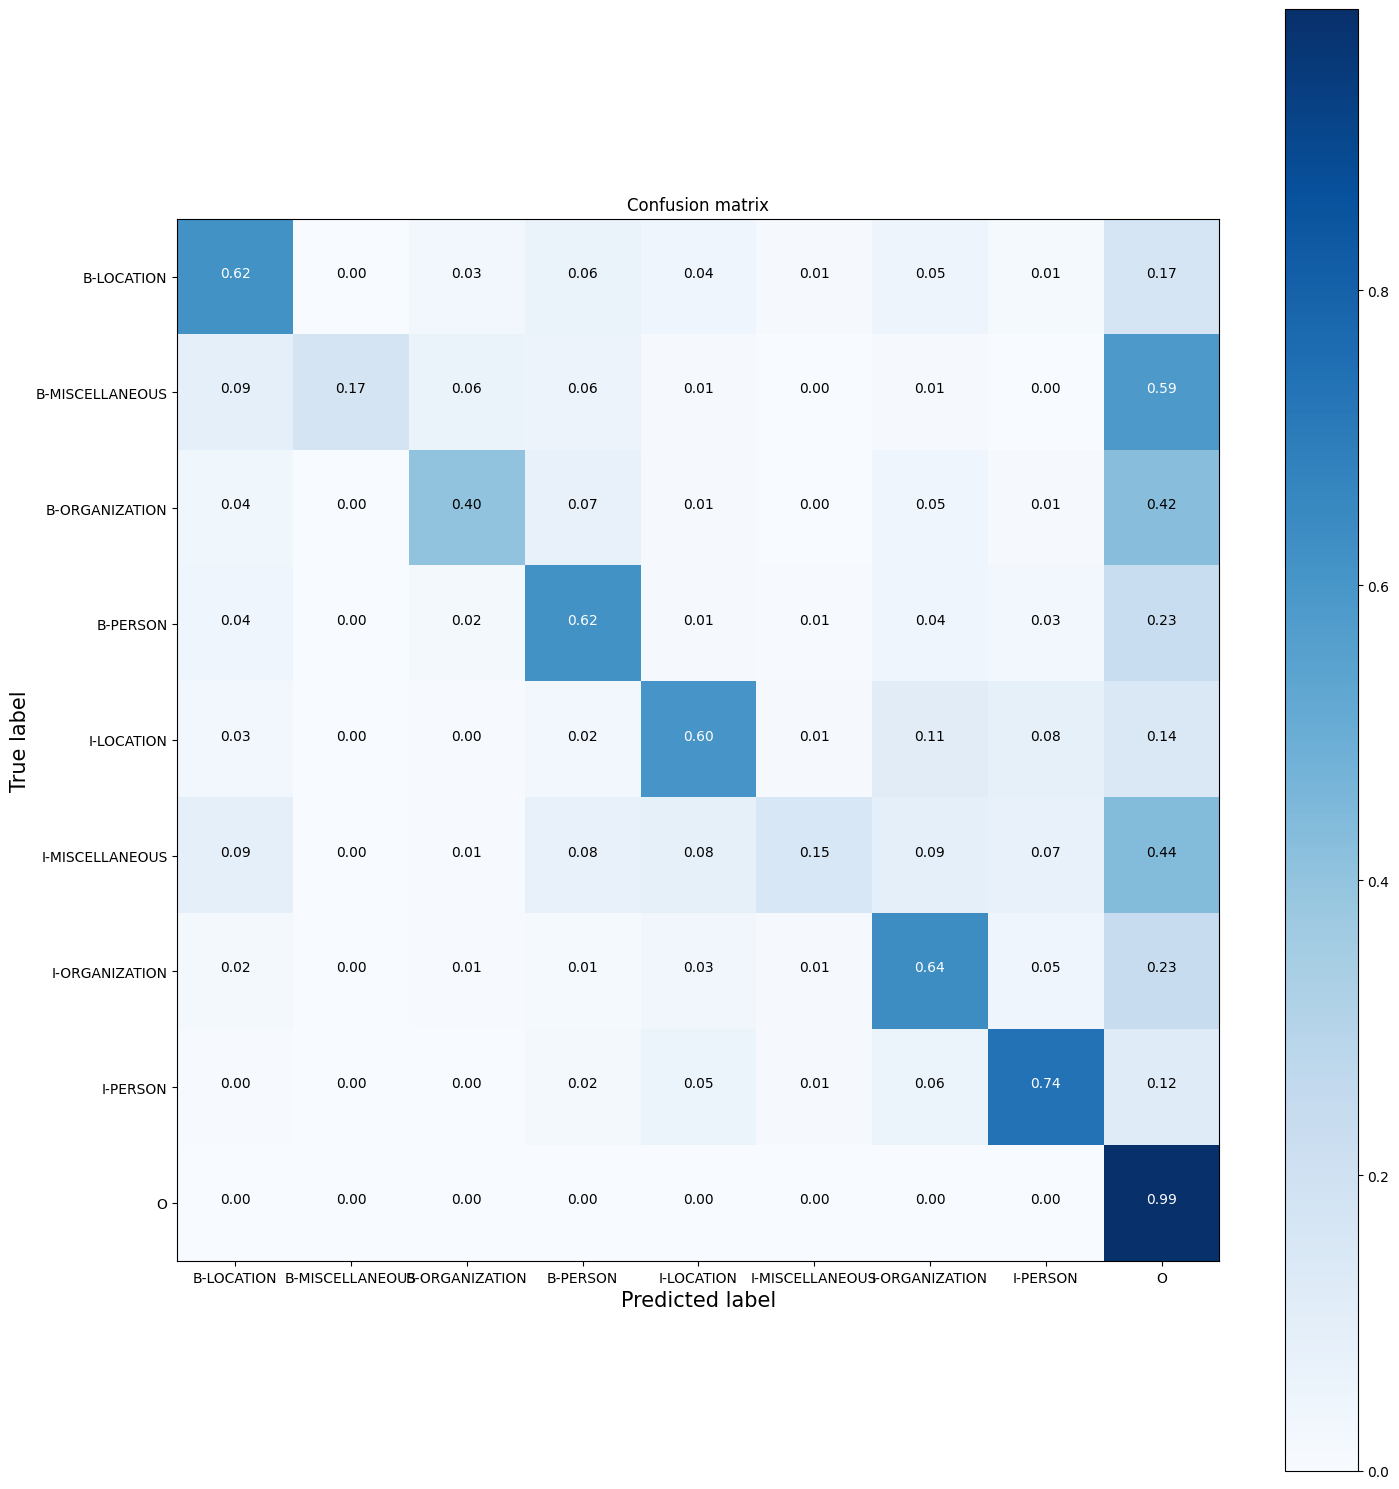

In [21]:
plot_confusion_matrix(y_true=y_test, y_pred=model.predict(X_test), normalize=True, title='Confusion matrix')

<Axes: >

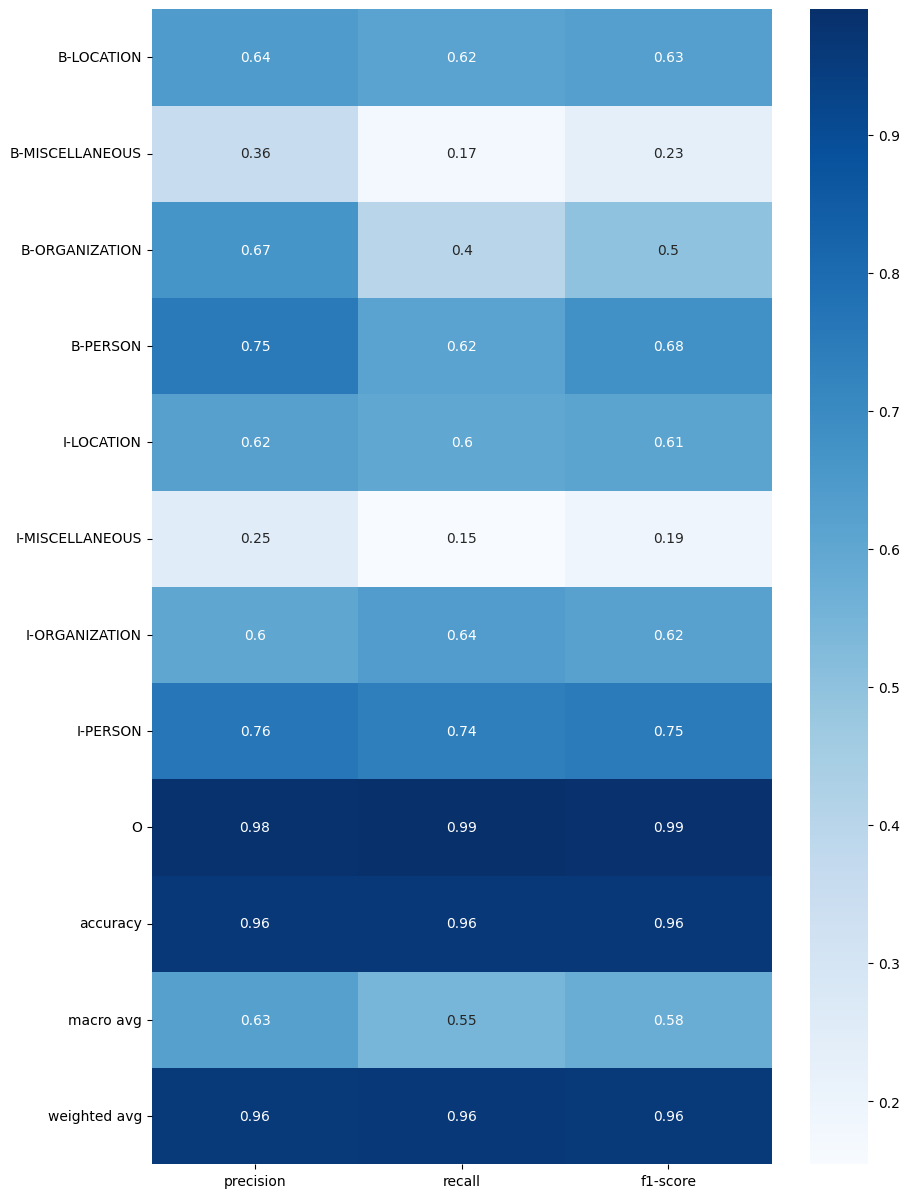

In [22]:
import pandas as pd
plt.figure(figsize=(10, 15))
sns.heatmap(pd.DataFrame(model.classification_report(x_test=X_test, y_test=y_test, output_dict=True)).iloc[:-1, :].T, annot=True, cmap='Blues')